# CHISEL - Co-HI Signals: Extraction from Line-intensity mapping

In [1]:
import os,sys#,#progressbar
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
sys.path.insert(1, '/home/amarins/ComponentSeparation/gmca/scripts')
import Extension4BINGO as cs
import copy

In [2]:
#######################################################
################   GENERAL INFORMATIONS   #############
#######################################################
method           = "ICA"
wtransform       = ["identity"]
maps_wout_mean   = True
apply_mask       = False
add_noise        = False

#######################################################
################   WAVELETS PARAMETERS   ##############
#######################################################
#####
# The main aim is to have:
# Starlet, Axisymmetric, spin-Directional, Wavelets Standard from PyWavelets, Curvelets, Counturlets, Shearlets, Ridgelets and so on
#####
J     = 1  #number of scales
use_c = True  # if you will use wavelet scale in the analysis

##############
# S2LET code
# If you to use wtransforms by S2Let code, please, fill in the variables below:
L        = -1 #If you write L<0, it will use L=3*nside
J_min    = 1
B        = 5     
N        = 3  # Number of directions (This is for Directional only)
spin     = 0  # set to 0 for temperature. if non-zero, plotting routines must be changed! (This is for Directional only)
upsample = 0  # 1 means all scales at full resolution L # 0 means multiresolution wavelet transform (This is for Directional only)
# In the S2LET code, J scales is defined by code and not by J above.

##############
# PyWavelets
Jpwt     = 1 #number of scales
pywttype = "haar" 

##############
# Needlets
needlet   = "mexican" # either mexican(=gaussian), or standard
Bneed     = 1.15            # filter is defined by function b(l/B**j), where j=freq
p         = 0.9             # this value is only for mexican needlet
fneed     = [15,24,30,34]   # number of freqs will be the number of scales (wavelet maps). Center of i-band will be approached given by l_center_i = B**freq_i (p=0)
lmax_need = -1

##############
# Curvelets
##############
# Counturlets
##############
# Shearlets
##############
# Ridgelets

#######################################################
#### COMPONENT SEPARATION #############################
#######################################################
n_s = 1  #number of sources to be estimated

######## FastICA PARAMETERS 
whiten = True  ######## Maintain True
fun = 'logcosh' #exp,logcosh or
max_iter = 20
tol = 0.01

######## GMCA PARAMETERS   
mints = 0.05 # min threshold (what is sparse compared to noise?)
nmax  = 100 # number of iterations (usually 100 is safe)
L0    = 0   # switch between L0 norm (1) or L1 norm (0)

#######################################################
AInit     = None
ColFixed  = None
whitening = False
epsi      = 1e-3
verbose   = False
#GMCAExtension
div          = 1 #  J+1  #J/div will should be even number
without_covx = True # if your mixmatrix estimated will use covariance matrix of the observer data with ponderation
# 0 <= noise factor <= 1
#noise_factor = 1  <-------------- Preciso que os mapas sejam todos separados

#######################################################
################   PATHS PARAMETERS   #################
#######################################################
#path outputs
pathout       = "/home/amarins/ComponentSeparation/gmca/outputs/simple_real" #Put here your path to the output cls
cl_type_save  = "reconstruction" #You should choice between reconstruction or residuals cls values
savefits      = True # or False
#######################################################
################   NAME FILES PARAMETERS   ############
#######################################################
# Name of FITS files inside of the pathmaps

#Directory names
dir_observed  = "/media/new-drive/CS_Cubes/White_Noise/input_wn"
dir_mask      = "/media/new-drive/amarins/maps/mask"
dir_prior     = "/media/new-drive/CS_Cubes/White_Noise/prior_wn"
dir_noise     = "/media/new-drive/CS_Cubes/Only_White_Noise_Masked"
dir_pure      = "/media/new-drive/CS_Cubes/No_Noise/prior_nn"

name_observed = "Cube_Input_WN_L10_M.fits"
name_mask     = "Mask_Bin.fits"
name_prior    = "Cube_Prior_WN_L10M.fits"
name_noise    = "bingo_WN_256_mK_CubeA_10Masked.fits"
name_pure     = "Cube_Prior_L10M.fits"

seed_used     = "L10"

In [3]:
params_maps = pd.Series({"without_mean":maps_wout_mean, "apply_mask":apply_mask, "add_noise":add_noise, "cl_type_save":cl_type_save,"iseed":seed_used})

params_CS   = pd.Series({"method":method,
                         "A_ini":AInit, "ColFixed":ColFixed, "whitening":whitening, "epsi":epsi, 
                         "verbose":verbose, "ns":n_s, "mints":mints,"nmax":nmax, "L0":L0, "division":div, 
                         "without_covx":without_covx,"whiten":whiten, "fun":fun, "max_iter":max_iter, "tol":tol})

params_WT   = pd.Series({"wtransform":np.asarray(wtransform), "use_c":use_c, "J":J, 
                         "L":L, "Jmin":J_min, "B": B, "N":N, "spin":spin, "upsample":upsample,
                         "Jpwt":Jpwt, "pywttype":pywttype.lower(),
                         "needlet":needlet, "Bneed":Bneed, "p":p, "fneed": fneed, "lmax_need":lmax_need})

params_path = pd.Series({"pathout":pathout, 
                          "dir_observed":dir_observed,  "dir_prior":dir_prior,   "dir_noise":dir_noise,   "dir_pure":dir_pure,  "dir_mask":dir_mask, 
                         "name_observed":name_observed,"name_prior":name_prior, "name_noise":name_noise, "name_pure":name_pure, "name_mask":name_mask})

In [4]:
params_maps["getdata"] = "observed"
subdirs = cs.checkdir(params_path.pathout, subdirs=["21cm","foregrounds","mixmatrix"],restart=True)

params_cs, params_wt = cs.load(params_CS,params_WT)
X = cs.getmaps(           params_maps, params_path)
X = cs.adaptation_maps(X, params_maps, params_path)
X = cs.maps2CSmaps(    X, params_wt  , params_cs)
cs.saveouts(mrec=X, params_path=params_path, params_maps=params_maps, params_WT=params_wt, params_CS=params_cs, subdirs=subdirs)

Component Analysis: Starting ICA method ...
Building reconstructed maps...
Building residuals maps...
Finished in: 0.27 min


In [37]:
X["residual"].keys()

dict_keys(['21cm', 'foregrounds'])

In [33]:
import healpy as hp
import warnings
warnings.filterwarnings("ignore")

Banda: 14


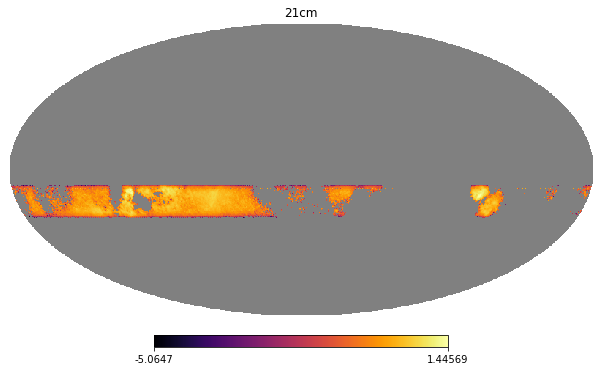

In [29]:
nbands = X['reconstruction']['21cm'].shape[0]
iband  = np.random.randint(nbands)
imap   = X['reconstruction']['21cm'][iband,:]
print("Banda: {}".format(iband))
hp.mollview(np.log10(imap), cmap="inferno",title="21cm");